# Sample stragegy with Feature Engineering

This notebook will illustrate how to tackle a new ML challenge from the feature engineering perspective. We will run very quickly over the data preparation and exploratory data analysis (EDA) phases since the goal is to illustrate how to work with features.

The dataset proposed is a random one selected from UCI, for binomial classification, with a mix of categorical and numerical features.

We will use the pyDataset library, simply because it saves a large amount of working time in preparing and getting data ready to be used. For those of you who prefer to stick to Pandas, it is OK! All the code for every single transformation performed with pyDataset is in the repo and documented, so you can copy the portions that you might need.

Remeber: the goal is to illustrate the process of Feature Engineering. That means:

  1. Prepare the data
  2. Setup a baseline for the model and the metric selected. This means that we need to know what is the metric obtained with a simple model when we do nothing on our features to later check if ourfeature engineering process is working properly.
  3. Start with feature construction: can we build new features?
  4. Continue with feature filtering: can we get rid of some features and keep our performance level?
  
Enjoy!

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Sample-stragegy-with-Feature-Engineering" data-toc-modified-id="Sample-stragegy-with-Feature-Engineering-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Sample stragegy with Feature Engineering</a></span><ul class="toc-item"><li><span><a href="#Loading-data" data-toc-modified-id="Loading-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Loading data</a></span><ul class="toc-item"><li><span><a href="#Data-types" data-toc-modified-id="Data-types-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Data types</a></span></li><li><span><a href="#Scaling-and-setting-the-target" data-toc-modified-id="Scaling-and-setting-the-target-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Scaling and setting the target</a></span></li></ul></li></ul></li><li><span><a href="#Feature-Engineering" data-toc-modified-id="Feature-Engineering-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Feature Engineering</a></span><ul class="toc-item"><li><span><a href="#Baseline-the-problem" data-toc-modified-id="Baseline-the-problem-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Baseline the problem</a></span></li><li><span><a href="#Encode-categorical-variables" data-toc-modified-id="Encode-categorical-variables-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Encode categorical variables</a></span><ul class="toc-item"><li><span><a href="#Keeping-everything-in-order" data-toc-modified-id="Keeping-everything-in-order-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Keeping everything in order</a></span></li></ul></li><li><span><a href="#Building-new-features." data-toc-modified-id="Building-new-features.-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Building new features.</a></span></li><li><span><a href="#Filter-features" data-toc-modified-id="Filter-features-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Filter features</a></span><ul class="toc-item"><li><span><a href="#RelieF" data-toc-modified-id="RelieF-2.4.1"><span class="toc-item-num">2.4.1&nbsp;&nbsp;</span>RelieF</a></span></li><li><span><a href="#Permutation-importance" data-toc-modified-id="Permutation-importance-2.4.2"><span class="toc-item-num">2.4.2&nbsp;&nbsp;</span>Permutation importance</a></span></li><li><span><a href="#Regularization-$-\ell_1$" data-toc-modified-id="Regularization-$-\ell_1$-2.4.3"><span class="toc-item-num">2.4.3&nbsp;&nbsp;</span>Regularization $ \ell_1$</a></span></li></ul></li><li><span><a href="#Summary" data-toc-modified-id="Summary-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Summary</a></span></li></ul></li></ul></div>

In [1]:
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from gplearn.genetic import SymbolicTransformer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from skrebate import ReliefF

import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

## Loading data

The official description of the dataset is:

    x0: 0,1 CATEGORICAL (formerly: a,b) 
    x1: continuous. 
    x2: continuous. 
    x3: 1,2,3 CATEGORICAL (formerly: p,g,gg) 
    x4: 1, 2,3,4,5, 6,7,8,9,10,11,12,13,14 CATEGORICAL (formerly: ff,d,i,k,j,aa,m,c,w, e, q, r,cc, x) 
    x5: 1, 2,3, 4,5,6,7,8,9 CATEGORICAL (formerly: ff,dd,j,bb,v,n,o,h,z) 
    x6: continuous. 
    x7: 1, 0 CATEGORICAL (formerly: t, f) 
    x8: 1, 0 CATEGORICAL (formerly: t, f) 
    x9: continuous. 
    x10: 1, 0 CATEGORICAL (formerly t, f) 
    x11: 1, 2, 3 CATEGORICAL (formerly: s, g, p) 
    x11: continuous. 
    x13: continuous. 
    x14: 1,2 class attribute (formerly: +,-)
    
So, we don't know anything from the business domain. Therefore we will only act upon the observed behaviour of the features.

Target variable is `x14` in our case.

In [2]:
data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/australian/australian.dat'
raw = pd.read_csv(data_url, header=None, delimiter=' ')
raw.columns = [f"x{i}" for i in range(raw.shape[1])]
raw.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14
0,1,22.08,11.46,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,0,22.67,7.00,2,8,4,0.165,0,0,0,0,2,160,1,0
2,0,29.58,1.75,1,4,4,1.250,0,0,0,1,2,280,1,0
3,0,21.67,11.50,1,5,3,0.000,1,1,11,1,2,0,1,1
4,1,20.17,8.17,2,6,4,1.960,1,1,14,0,2,60,159,1


### Data types

Convert the features to the proper format:

In [3]:
for feature in ['x0', 'x3', 'x4', 'x5', 'x7', 'x8', 'x10', 'x11', 'x14']:
    raw[feature] = raw[feature].astype("category")

raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   x0      690 non-null    category
 1   x1      690 non-null    float64 
 2   x2      690 non-null    float64 
 3   x3      690 non-null    category
 4   x4      690 non-null    category
 5   x5      690 non-null    category
 6   x6      690 non-null    float64 
 7   x7      690 non-null    category
 8   x8      690 non-null    category
 9   x9      690 non-null    int64   
 10  x10     690 non-null    category
 11  x11     690 non-null    category
 12  x12     690 non-null    int64   
 13  x13     690 non-null    int64   
 14  x14     690 non-null    category
dtypes: category(9), float64(3), int64(3)
memory usage: 40.4 KB


Now, we've all features (more or less) in the correct type. Let's check if we'have some NA's.

In [4]:
raw.describe()

,x1,x2,x6,x9,x12,x13
count,690.000000,690.000000,690.000000,690.00000,690.000000,690.000000
mean,31.568203,4.758725,2.223406,2.40000,184.014493,1018.385507
std,11.853273,4.978163,3.346513,4.86294,172.159274,5210.102598
min,13.750000,0.000000,0.000000,0.00000,0.000000,1.000000
25%,22.670000,1.000000,0.165000,0.00000,80.000000,1.000000
50%,28.625000,2.750000,1.000000,0.00000,160.000000,6.000000
75%,37.707500,7.207500,2.625000,3.00000,272.000000,396.500000
max,80.250000,28.000000,28.500000,67.00000,2000.000000,100001.000000


Seems that the dataset presents no NA's, and all features are complete. We're not checking anything else in this exercise, but EDA should be much more thorough.

### Scaling and setting the target

The following piece of code scale ONLY numeric features (no need to specify) and then converts the target variable (`x14`) to numerical (by default it is an `object` type), and finally is set as the target variable.

In [5]:
from sklearn.preprocessing import StandardScaler

# This is converting all my categoricals into numericals but
# I will keep a copy of this list of feature names into 'categoricals'
categoricals = raw.columns[raw.dtypes == "category"].tolist()
numericals = raw.columns[raw.dtypes != "category"].tolist()
for categorical in categoricals:
    raw[categorical] = raw[categorical].astype(np.int16)
categoricals.remove('x14')

feature_names = list(raw.columns).remove('x14')
scaler = StandardScaler()
raw[numericals] = scaler.fit_transform(raw[numericals])
raw.head()


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14
0,1,-0.801052,1.347111,2,4,4,-0.190906,0,0,-0.493887,1,2,-0.488358,0.037380,0
1,0,-0.751240,0.450548,2,8,4,-0.615536,0,0,-0.493887,0,2,-0.139591,-0.195413,0
2,0,-0.167856,-0.604823,1,4,4,-0.291083,0,0,-0.493887,1,2,0.557943,-0.195413,0
3,0,-0.835667,1.355152,1,5,3,-0.664877,1,1,1.769760,1,2,-1.069637,-0.195413,1
4,1,-0.962306,0.685745,2,6,4,-0.078768,1,1,2.387119,0,2,-0.720870,-0.165066,1


In [6]:
X = raw.drop(['x14'], axis=1)
y = raw['x14']

# Feature Engineering

At this point you should spend a long time running your exploratory data analysis to check that everything is properly balanced and meaninful, and probably proposing some combinations of variables or levels. But we don't want to concentrate on that, but rather on the FE process. Roughly, my strategy will be 

- rebuild our categorical variables into something more numeric, 
- use some external tools to build new features synthetically, and from there 
- check if we can filter out some features to finally 
- adjust a regularization parameter for my model.


## Baseline the problem

BUT, first of all, you must **BASELINE** your model. This means that we need a reference to know whether our proposed changes to the features are making the model better or worse.

In [7]:
model = LogisticRegression(
    # penalty='l1',
    solver='liblinear',
    C=1.0)
model.fit(X, y)

LogisticRegression(solver='liblinear')

In [8]:
final_scores = {}
scores = cross_val_score(model, X, y, cv=5)
print("Accuracy: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

final_scores['baseline'] = scores.mean()

Accuracy: 0.857 (+/- 0.08)


## Encode categorical variables

Let's see if we improve our results by re-encode the categorical features into numerical by applying target encoding. To do so, I will use an incubator library from scikit learn called `category_encoders` that you can easily install by typing:

```sh
$ pip install category_encoders
```

Check out [here](https://github.com/scikit-learn-contrib/category_encoders) for more information.

First thing to do is to create the encoder indicating what columns do I want to encode. I will do that by passing a list with the names of the categorical variables, which I get by calling `raw.categorical_features`. From there I only have to use the `fit_transform` convention call in `scikit_learn` to get the resulting DataFrame.

In [9]:
encoder = ce.target_encoder.TargetEncoder(cols=categoricals)
X_transformed = encoder.fit_transform(X, y)
X_transformed.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13
0,0.440171,-0.801052,1.347111,0.495238,0.274510,0.424020,-0.190906,0.069909,0.248101,-0.493887,0.462025,0.4592,-0.488358,0.037380
1,0.454955,-0.751240,0.450548,0.495238,0.452055,0.424020,-0.615536,0.069909,0.248101,-0.493887,0.430481,0.4592,-0.139591,-0.195413
2,0.454955,-0.167856,-0.604823,0.276074,0.274510,0.424020,-0.291083,0.069909,0.248101,-0.493887,0.462025,0.4592,0.557943,-0.195413
3,0.454955,-0.835667,1.355152,0.276074,0.300018,0.375064,-0.664877,0.786704,0.708475,1.769760,0.462025,0.4592,-1.069637,-0.195413
4,0.440171,-0.962306,0.685745,0.495238,0.351852,0.424020,-0.078768,0.786704,0.708475,2.387119,0.430481,0.4592,-0.720870,-0.165066


Now, let's measure if our model loses some accuracy, or holds. We will use CV with our base_model, but we're passing the transformed dataframe (`X_transformed`) instead of the original one.

In [10]:
model.fit(X_transformed, y)
scores = cross_val_score(model, X_transformed, y, cv=5)
print("Accuracy: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

final_scores['target encoding'] = scores.mean()

Accuracy: 0.865 (+/- 0.07)


I left as an exercise to check some other encoders, or even more interestingly, to use the default onehot encoding and see what is the result.

### Keeping everything in order

Once that I see that my new features (numeric instead of categorical) are working fine, I decide to keep my dataset updated with the new features. The best way of doing it is to create a new dataset from the resulting dataframe of the previous step, and join it with the target variable.

In [11]:
data = pd.DataFrame(pd.concat([X_transformed, y], axis=1))
data['x14'] = data['x14'].astype(np.int16)
data[numericals] = StandardScaler().fit_transform(data[numericals])

X = data[list(data.columns)].drop(['x14'], axis=1)
y = data['x14']

data.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14
0,0.440171,-0.801052,1.347111,0.495238,0.274510,0.424020,-0.190906,0.069909,0.248101,-0.493887,0.462025,0.4592,-0.488358,0.037380,0
1,0.454955,-0.751240,0.450548,0.495238,0.452055,0.424020,-0.615536,0.069909,0.248101,-0.493887,0.430481,0.4592,-0.139591,-0.195413,0
2,0.454955,-0.167856,-0.604823,0.276074,0.274510,0.424020,-0.291083,0.069909,0.248101,-0.493887,0.462025,0.4592,0.557943,-0.195413,0
3,0.454955,-0.835667,1.355152,0.276074,0.300018,0.375064,-0.664877,0.786704,0.708475,1.769760,0.462025,0.4592,-1.069637,-0.195413,1
4,0.440171,-0.962306,0.685745,0.495238,0.351852,0.424020,-0.078768,0.786704,0.708475,2.387119,0.430481,0.4592,-0.720870,-0.165066,1


## Building new features.

Now I aim at gaining more expresiveness, or finding new sources of information from potential interaction effects among the features. To do so, I will experiment with Genetic Programming and the evolutionary way of finding new features.

We will use the [GPLearn package](https://gplearn.readthedocs.io/en/stable/) in case you want to read a bit more about it.

In [12]:
function_set = ['add', 'sub', 'mul', 'div', 'sqrt', 'log',
                'abs', 'neg', 'inv', 'max', 'min']
gp = SymbolicTransformer(generations=10,
                         population_size=1000,
                         hall_of_fame=100,
                         n_components=12,
                         function_set=function_set,
                         parsimony_coefficient=0.0005,
                         max_samples=0.9,
                         verbose=1,
                         random_state=123,
                         n_jobs=-1)
gp.fit(X, y)
gp_features = gp.transform(X)

print(f'{gp_features.shape[1]} new features generated')

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    10.81         0.191621        2         0.742362         0.536134     44.08s
   1     6.81         0.535364        5         0.751129         0.581991      6.43s
   2     4.03         0.650962       10         0.757723         0.688939      6.78s
   3     4.63         0.664461        5         0.773389          0.60125      5.66s
   4     6.82         0.664806        5         0.777685         0.557035      5.20s
   5     8.27         0.677028        5         0.778912         0.517865      4.09s
   6     8.66         0.696059       14         0.780155         0.501685      3.14s
   7     9.64         0.714599        8         0.776491         0.537768      2.08s
   8    10.52         0.716678       16         0.780794         0.594212  

I don't know yet if my features will improve my model's accuracy (hope so!), but I must include these new features resulting from the last call (`gp_features`), as new columns in my dataset. The easiest way of doing it is to simply call the method `.add_column()`. But we need to build a proper dataframe with names for the new values generated.

In [13]:
# Build a dataframe from the set of best new features generated.
new_dataframe = pd.DataFrame(gp_features)
# Set the name of the dataframe columns as 'gp#' where # is a number.
new_dataframe.columns = ['gp{}'.format(i) for i in range(len(list(new_dataframe)))]

# Add the new dataframe as new columns of my dataset (update the variable X)
data = pd.concat([data, new_dataframe], axis=1)
feature_names = list(data.columns)
data[feature_names] = StandardScaler().fit_transform(data[feature_names])
X = data.drop(['x14'], axis=1)

# Show it
data.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,gp2,gp3,gp4,gp5,gp6,gp7,gp8,gp9,gp10,gp11
0,-0.688737,-0.801052,1.347111,0.530817,-0.908439,-0.164736,-0.190906,-1.047504,-0.864196,-0.493887,...,-1.023569,-1.059801,-1.016658,-1.063861,1.035039,-0.951661,-1.015921,-1.036339,-0.955878,-0.984745
1,1.451933,-0.751240,0.450548,0.530817,0.038630,-0.164736,-0.615536,-1.047504,-0.864196,-0.493887,...,-1.014037,-0.959564,-0.994444,-0.990841,1.035039,-0.944477,-1.015921,-0.947867,-0.955878,-0.984745
2,1.451933,-0.167856,-0.604823,-1.761826,-0.908439,-0.164736,-0.291083,-1.047504,-0.864196,-0.493887,...,-1.023569,-1.059801,-1.016658,-1.063861,1.035039,-0.951661,-1.015921,-1.036339,-0.955878,-0.984745
3,1.451933,-0.835667,1.355152,-1.761826,-0.772373,-0.550450,-0.664877,0.954650,1.157144,1.769760,...,0.870681,0.740453,0.923622,0.837730,-1.105700,0.714339,1.182030,0.744502,1.324070,1.105816
4,-0.688737,-0.962306,0.685745,0.530817,-0.495877,-0.164736,-0.078768,0.954650,1.157144,2.387119,...,0.950592,0.844304,1.009285,0.937370,-1.105700,0.854629,1.182030,0.880663,1.324070,1.151514


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 27 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x0      690 non-null    float64
 1   x1      690 non-null    float64
 2   x2      690 non-null    float64
 3   x3      690 non-null    float64
 4   x4      690 non-null    float64
 5   x5      690 non-null    float64
 6   x6      690 non-null    float64
 7   x7      690 non-null    float64
 8   x8      690 non-null    float64
 9   x9      690 non-null    float64
 10  x10     690 non-null    float64
 11  x11     690 non-null    float64
 12  x12     690 non-null    float64
 13  x13     690 non-null    float64
 14  x14     690 non-null    float64
 15  gp0     690 non-null    float64
 16  gp1     690 non-null    float64
 17  gp2     690 non-null    float64
 18  gp3     690 non-null    float64
 19  gp4     690 non-null    float64
 20  gp5     690 non-null    float64
 21  gp6     690 non-null    float64
 22  gp

In [15]:
model.fit(X, y)
scores = cross_val_score(model, X, y, cv=5)
print("Accuracy: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

final_scores['new features'] = scores.mean()

Accuracy: 0.865 (+/- 0.07)


No big impact after adding lots of features. Maybe we've too much noise in the model and we must filter out some of them, or this process is not capable of adding extra information to the modeling task

## Filter features

Let's filter out some features, as our model is now 26-dimensional and the accuracy is kept under the same values.

### RelieF

I will try [Relief](https://github.com/EpistasisLab/scikit-rebate) (`pip install skrebate`) and Permutation importance.

In [16]:
fs = ReliefF(n_features_to_select=10, n_neighbors=100)
X_filtered = fs.fit_transform(X.values, y.values)

In [17]:
model.fit(X_filtered, y)
scores = cross_val_score(model, X_filtered, y, cv=5)
print("Accuracy: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.859 (+/- 0.06)


It's a bit impressive how if we remove 16 out of 26 features we still can get roughly the same accuracy (with even lower variance!). Let's now try something more visual. We don't know if 10 was the best possible option in this exercise, so let's try to find out what is the optimal set of features to select in RelieF.

In [18]:
scores = []
param_range = range(1, X.shape[1])
max_score = -1.0
for num_features in param_range:
    fs = ReliefF(n_features_to_select=num_features, n_neighbors=25)
    X_filtered = fs.fit_transform(X.values, y.values)
    model.fit(X_filtered, y)
    score = cross_val_score(model, X_filtered, y, cv=5)
    scores.append(score.mean())
    if score.mean() > max_score:
        max_score = score.mean()
        
final_scores['relief'] = max_score

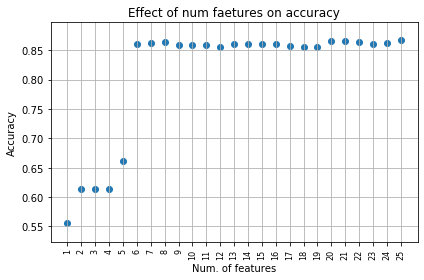

In [19]:
# Plot the scores
plt.figure(figsize=(6, 4))
plt.scatter(range(len(scores)), scores)
plt.xticks(range(len(scores)), [f'{a:.2g}' for a in param_range])
plt.xticks(fontsize=8, rotation=90)
plt.ylabel('Accuracy')
plt.xlabel('Num. of features')
plt.title('Effect of num faetures on accuracy')
plt.grid(axis='both')
plt.tight_layout()
plt.show()

So, let's use the number of features that produce the max accuracy and re-evaluate our model!

### Permutation importance

Let's try now with permutation importance. We will use the trained model with all the features.

In [20]:
model.fit(X, y)
r = permutation_importance(model, X, y, n_repeats=30, random_state=0)

# Importances in descending order
imp_indexes = r.importances_mean.argsort()[::-1]
imp_labels  = [data.columns[i] for i in imp_indexes]
imp_values  = [r.importances_mean[i] for i in imp_indexes]
imp_std     = [r.importances_std[i] for i in imp_indexes]

Plot the importances obtained to see what is the situation more clearly.

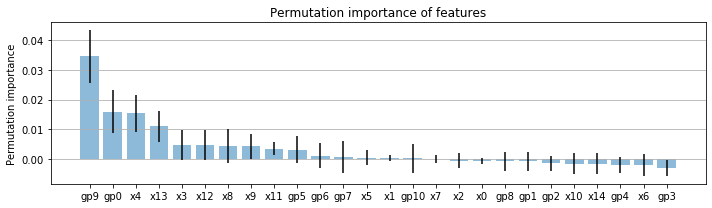

In [21]:
# Plot the permutation importance of the features
fig, ax = plt.subplots()
fig.set_size_inches(10,3)
ax.bar(range(len(imp_indexes)), imp_values,  yerr=imp_std, 
       align='center', alpha=0.5, ecolor='black', capsize=0)
ax.set_ylabel('Permutation importance')
ax.set_xticks(range(len(imp_indexes)))
ax.set_xticklabels(imp_labels)
ax.set_title('Permutation importance of features')
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

As we can see, most of them present a very low _permutation importance_ which means that when shuffling its content along the dataset it doesn't really impact the final accuracy metric obtained. We can easily infer from this, that we can skip most of them.

We will try to keep only the top-3 features and see what is the final accuracy of the model.

In [22]:
num_features = 3
X_selected = []
importances = r.importances_mean.argsort()[::-1] # reverse order array
for i in importances[:num_features]:             # take only the first num_feats
    X_selected.append(data.columns[i])

# And now, fit the model with those features and score it with CV.
model.fit(data[X_selected], y)
scores = cross_val_score(model, data[X_selected], y, cv=5)
print("Accuracy: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.865 (+/- 0.05)


But, again, randomly guessing if 3 is the best nr of features is not acceptable most of the times. We must build a simple loop that will try every possible nr of features (within a reasonable range) to get to the conclussion of what is the best number to be used.

Let's do that. I will loop through a number of features between 1 and 15. I will build a dataframe at each iteration with only the top most `num_features` important features, and I will use them to evaluate the model. Finally I will plot the result.

In [24]:
scores = []
param_range = range(1, 15)
importances = r.importances_mean.argsort()[::-1] # reverse order array
max_score = -1.0
for num_features in param_range:
    X_filtered = pd.DataFrame()
    for i in importances[:num_features]:
        column_name = data.columns[importances[i]]
        column_data = data[column_name].values
        X_filtered[column_name] = column_data
    model.fit(X_filtered, y)
    score = cross_val_score(model, X_filtered, y, cv=5)
    scores.append(score.mean())
    if score.mean() > max_score:
        max_score = score.mean()
        
final_scores['permutation importance'] = max_score

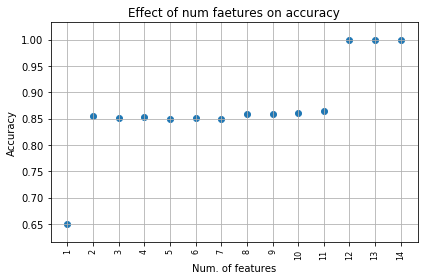

In [25]:
# Plot the scores
plt.figure(figsize=(6, 4))
plt.scatter(range(len(scores)), scores)
plt.xticks(range(len(scores)), [f'{a:.2g}' for a in param_range])
plt.xticks(fontsize=8, rotation=90)
plt.ylabel('Accuracy')
plt.xlabel('Num. of features')
plt.title('Effect of num faetures on accuracy')
plt.grid(axis='both')
plt.tight_layout()
plt.show()

A model with 9 features if performing really well. So we stick with that. We can see that from our GP experiment that produced 26 features in our dataset and .87 accuracy value, we can remove 15 of those features and get the very same result.

### Regularization $ \ell_1$

We still have a final approach which is regulariation. We must select the value of lambda which produces the best posible performance for our model. This parameter controls how much penalty is added to our model (logistic regression with $ \ell_1 $). 

In [26]:
alpha_range = [10**x for x in np.arange(-3, 1, 0.25)]
l1_scores = []
for alpha in alpha_range:
    model = LogisticRegression(penalty='l1', solver='liblinear', C=alpha)
    model.fit(X, y)
    score = cross_val_score(model, X, y, cv=5)
    l1_scores.append(score.mean())

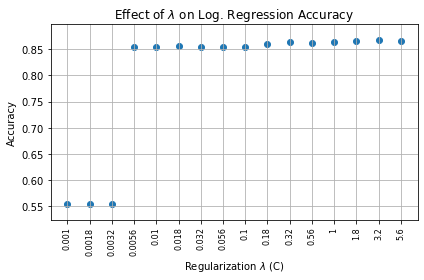

In [27]:
# Plot the scores
plt.figure(figsize=(6, 4))
plt.scatter(range(len(l1_scores)), l1_scores)
plt.xticks(range(len(l1_scores)), [f'{a:.2g}' for a in alpha_range])
plt.xticks(fontsize=8, rotation=90)
plt.ylabel('Accuracy')
plt.xlabel('Regularization $\lambda$ (C)')
plt.title('Effect of $\lambda$ on Log. Regression Accuracy')
plt.grid(axis='both')
plt.tight_layout()
plt.show()

From the plot above, we can infer that we must use a value of regularization that is greater than 3.2e-02.

So, let's measure our model with the C that results in the maximum accuracy to validate our result.

In [28]:
index_of_Cmax = np.argmax(l1_scores)
C_max = alpha_range[index_of_Cmax]
print(f'Max C is {C_max:.2g} at position {index_of_Cmax}')

Max C is 3.2 at position 14


In [29]:
model = LogisticRegression(penalty='l1', solver='liblinear', C=C_max)
model.fit(X, y)
scores = cross_val_score(model, X, y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

final_scores['regularization'] = scores.mean()

Accuracy: 0.87 (+/- 0.06)


Let's plot the coefficients of the model in decreasing importance to know what are the features that are more important for the model.

In [31]:
# Importances in descending order
coefs = model.coef_[0]
imp_indexes = coefs.argsort()[::-1]
imp_labels  = [data.columns[i] for i in imp_indexes]
imp_values  = [coefs[i] for i in imp_indexes]

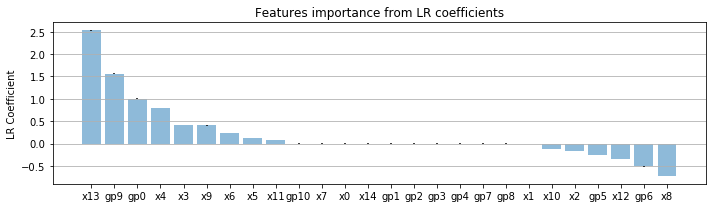

In [32]:
# Plot the coefficients importance of the features
fig, ax = plt.subplots()
fig.set_size_inches(10,3)
ax.bar(range(len(imp_indexes)), imp_values,  yerr=imp_std, 
       align='center', alpha=0.5, ecolor='black', capsize=0)
ax.set_ylabel('LR Coefficient')
ax.set_xticks(range(len(imp_indexes)))
ax.set_xticklabels(imp_labels)
ax.set_title('Features importance from LR coefficients')
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

## Summary

Let's plot the summary of our techiques by plotting the CV score obtained after applying each individual technique.

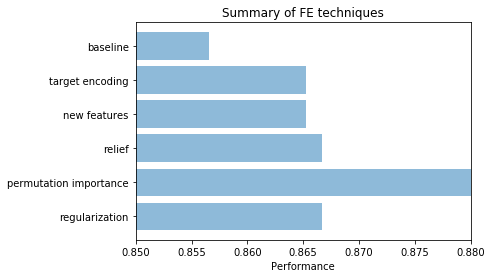

In [33]:
techniques = list(final_scores.keys())
y_pos = np.arange(len(techniques))
performance = list(final_scores.values())

fig, ax = plt.subplots()
ax.barh(y_pos, performance, alpha=0.5, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(techniques)
ax.invert_yaxis()
ax.set_xlabel('Performance')
ax.set_xlim(0.85, 0.88)
ax.set_title('Summary of FE techniques')

plt.show()